# Pre-processing some data, that could be useful for the model

In [1]:
import gc
import time
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


### Finding the 'best hours' of the day is or what hours during the day have more activity across the whole week. 

In [2]:
file_names = ["ctr_15.csv", "ctr_16.csv", "ctr_17.csv", "ctr_18.csv", "ctr_19.csv", "ctr_20.csv", "ctr_21.csv"]
# Read and concatenate all the CSV files for the training data
train_data = pd.concat([pd.read_csv(file) for file in file_names])

In [12]:
# Load the test data
test_data = pd.read_csv("ctr_test.csv")

In [3]:
# Convert auction_time (Unix time) to datetime
train_data['auction_time'] = pd.to_datetime(train_data['auction_time'], unit='s')

# Feature Engineering: Creating new features from auction_time
train_data['auction_hour'] = train_data['auction_time'].dt.hour             # Hour of the auction
train_data['auction_minute'] = train_data['auction_time'].dt.minute         # Minute of the auction
train_data['auction_day_of_week'] = train_data['auction_time'].dt.dayofweek # Day of the week (Monday=0, Sunday=6)
train_data['auction_day'] = train_data['auction_time'].dt.day               # Day of the month
train_data['auction_month'] = train_data['auction_time'].dt.month           # Month of the year
train_data['auction_year'] = train_data['auction_time'].dt.year             # Year of the auction

C:\Users\User\AppData\Local\Temp\ipykernel_19104\1452711142.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette='viridis')


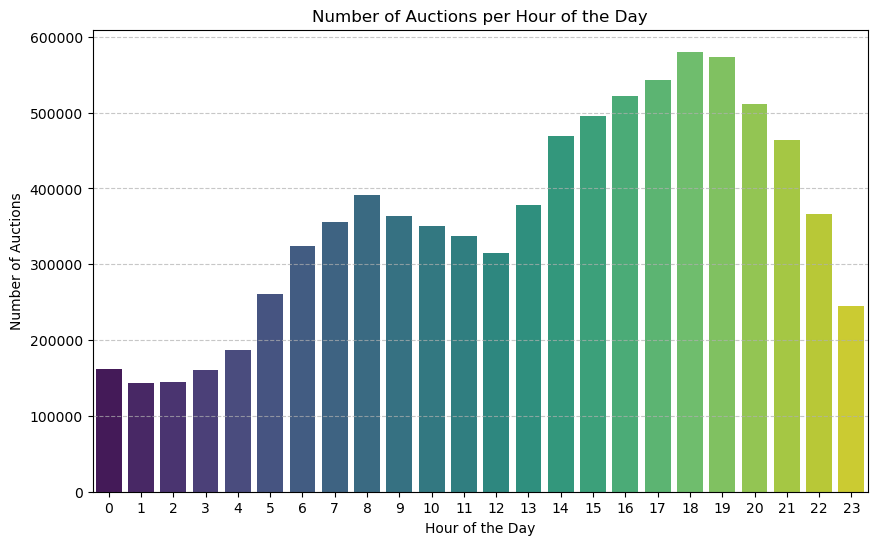

In [4]:
# COUNT PLOT

# Count the number of auctions per hour
hourly_counts = train_data['auction_hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Auctions')
plt.title('Number of Auctions per Hour of the Day')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

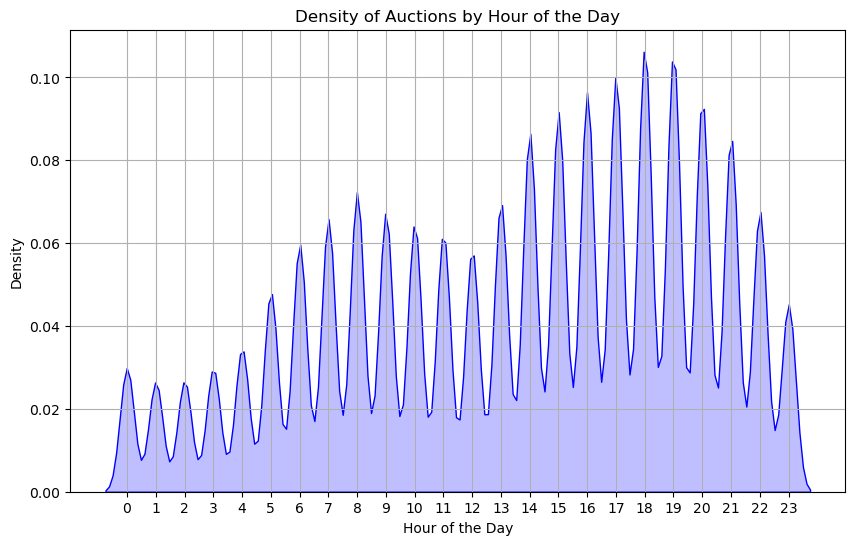

In [5]:
# DENSITY PLOT
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_data, x='auction_hour', fill=True, color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Density')
plt.title('Density of Auctions by Hour of the Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

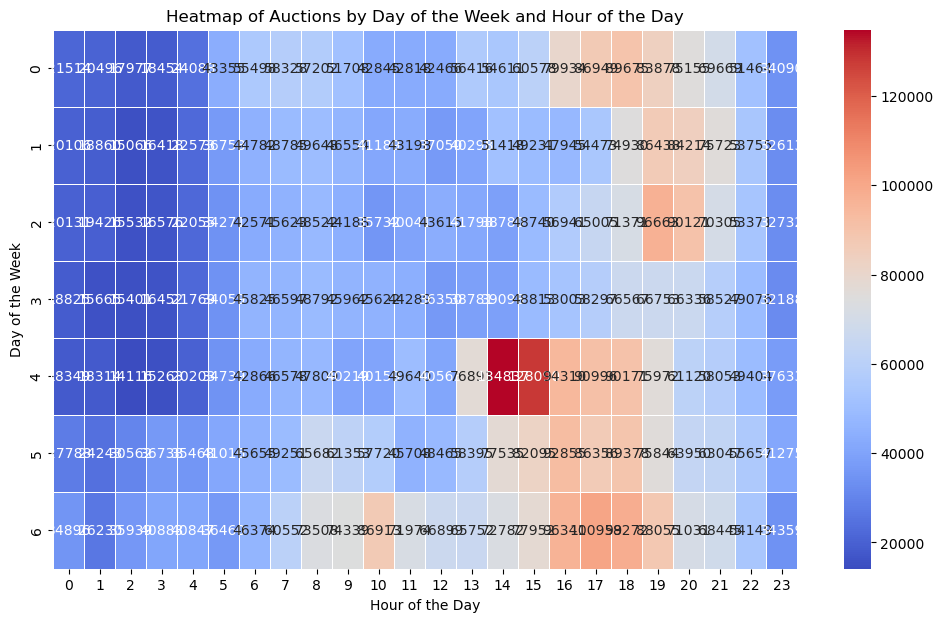

In [6]:
# HEATMAP
# Create a pivot table for heatmap
heatmap_data = train_data.groupby(['auction_day_of_week', 'auction_hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 7))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d', cbar=True, linewidths=.5)
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Heatmap of Auctions by Day of the Week and Hour of the Day')
plt.show()

<Figure size 1400x700 with 0 Axes>

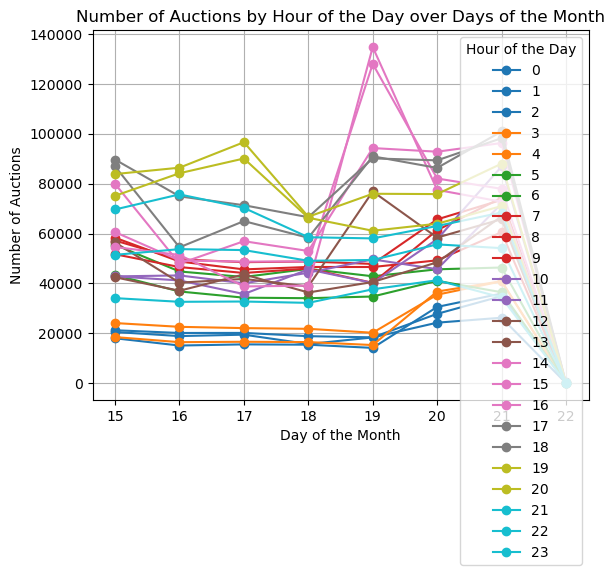

In [7]:
# TIME SERIES
# Aggregate data by day and hour
time_series_data = train_data.groupby(['auction_day', 'auction_hour']).size().unstack().fillna(0)

plt.figure(figsize=(14, 7))
time_series_data.plot(kind='line', marker='o', colormap='tab10')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Auctions')
plt.title('Number of Auctions by Hour of the Day over Days of the Month')
plt.legend(title='Hour of the Day')
plt.grid(True)
plt.show()

In [10]:
# Step 1: Identify the most popular hours (good hours)
auction_hour_counts = train_data['auction_hour'].value_counts().sort_values(ascending=False)

# Step 2: Define good hours (e.g., top 25% most frequent hours)
top_25_percent = int(0.25 * len(auction_hour_counts))
good_hours = auction_hour_counts.index[:top_25_percent].tolist()

# # Step 3: Create the 'good_hours' feature
# for df in [train_data, test_data]:
#     df['good_hours'] = df['auction_hour'].apply(lambda x: 1 if x in good_hours else 0)

# Now the 'good_hours' feature is added, indicating whether the auction occurred during a popular hour.

print("top 25", top_25_percent)

print("good hours", good_hours)

top 25 6
good hours [18, 19, 17, 16, 20, 15]


### Feature Engineering for auction_list_* Variables

a) Count of Items in the List -> create a new feature that counts the number of items in each list. This can help represent the complexity of each auction or action.

In [14]:
for col in ['action_list_0', 'action_list_1', 'action_list_2']:
    train_data[f'{col}_count'] = train_data[col].apply(lambda x: len(str(x).split(',')))
    test_data[f'{col}_count'] = test_data[col].apply(lambda x: len(str(x).split(',')))


b) Unique Items in List -> create a feature that counts the number of unique items in the list. This would be useful if there are many repeated categories or entity IDs.

In [15]:
for col in ['action_list_0', 'action_list_1', 'action_list_2']:
    train_data[f'{col}_unique_count'] = train_data[col].apply(lambda x: len(set(str(x).split(','))))
    test_data[f'{col}_unique_count'] = test_data[col].apply(lambda x: len(set(str(x).split(','))))
